In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from RateTraining import *
from RateTraining import RateTraining
from LIFTraining import *

### generate inputs to be used in training 

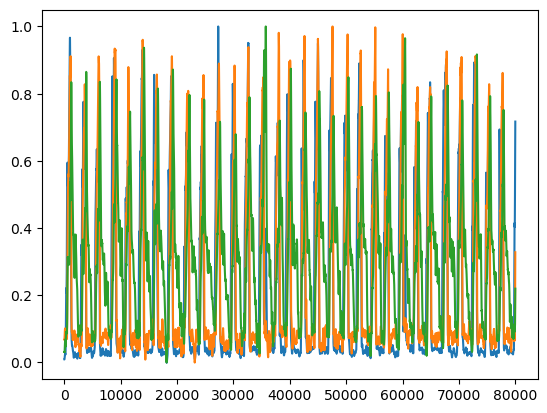

In [3]:
raw_waveforms = np.transpose(np.load("raw_form80.npy"))
freqs = np.load("fin80.npy")

fin = freqs[:]
hfout = raw_waveforms[0][:]
pfout = raw_waveforms[1][:]
vfout = raw_waveforms[2][:]

fout = np.vstack((hfout, pfout, vfout))

plt.plot(hfout)
plt.plot(pfout)
plt.plot(vfout)

[0, 1203, 3854, 6265, 9177, 11607, 14097, 16571, 19222, 22125, 24783, 27599, 30349, 32810, 35422, 38188, 40163, 42749, 45196, 47682, 50360, 52703, 55255, 57525, 60119, 62775, 65051, 67979, 70577, 73187, 75492, 77903]


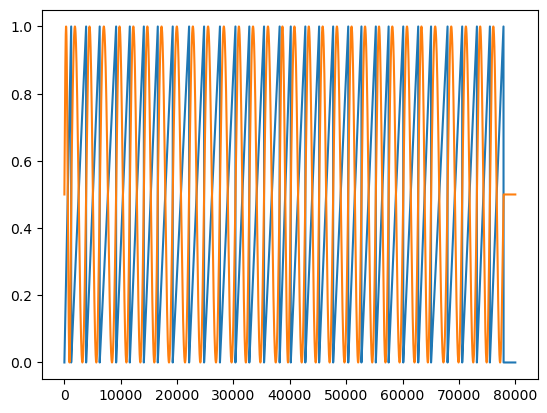

In [4]:
steps = [0]
for i in range(1, len(freqs)):
    if freqs[i] != freqs[i - 1]:
        steps.append(i)
print(steps)

phase = np.zeros(len(freqs))
for i in range(1, len(steps)):
    phase[steps[i - 1]:steps[i]] = np.linspace(0, 2 * np.pi, num = steps[i] - steps[i - 1])

phaseinp = phase / (2 * np.pi)
psininp = (np.sin(phase) + 1) / 2
plt.plot(phaseinp)
plt.plot(psininp)

### initialize parameters and inputs

In [5]:
start = 1203
stop = 75492
trainstop = 9177

netsize = 1000

In [6]:
uhfoutd = np.outer(sp.stats.uniform.rvs(size = netsize), hfout[start:stop])
upfoutd = np.outer(sp.stats.uniform.rvs(size = netsize), pfout[start:stop])
uvfoutd = np.outer(sp.stats.uniform.rvs(size = netsize), vfout[start:stop])

uhfout = np.outer(sp.stats.uniform.rvs(size = netsize), hfout[start:stop])
upfout = np.outer(sp.stats.uniform.rvs(size = netsize), pfout[start:stop])
uvfout = np.outer(sp.stats.uniform.rvs(size = netsize), vfout[start:stop])

ufind = np.outer(sp.stats.uniform.rvs(size = netsize), fin[start:stop])
ufin = np.outer(sp.stats.uniform.rvs(size = netsize), fin[start:stop])

uphaseind = np.outer(sp.stats.uniform.rvs(size = netsize), phaseinp[start:stop])
uphasein = np.outer(sp.stats.uniform.rvs(size = netsize), phaseinp[start:stop])

upsinind = np.outer(sp.stats.uniform.rvs(size = netsize), psininp[start:stop])
upsinin = np.outer(sp.stats.uniform.rvs(size = netsize), psininp[start:stop])

fouttrain = fout[:, start:stop]

In [7]:
rpars = create_default_params_rate()
rpars['net_size'] = netsize
rpars['total_time'] = stop - start
rpars['runtime'] = stop - start

### initalize rate model

In [8]:
dnet = RateTraining(rpars)

In [9]:
ufoutd = uhfoutd + upfoutd + uvfoutd
# stabilize network before creating auxillary targets
for i in range(3):
    dnet.runGPU(ufoutd +upsinind)

_, Hxd = dnet.runGPU(ufoutd + upsinind)

Text(0.5, 1.0, 'Sample driven neuronal behavior')

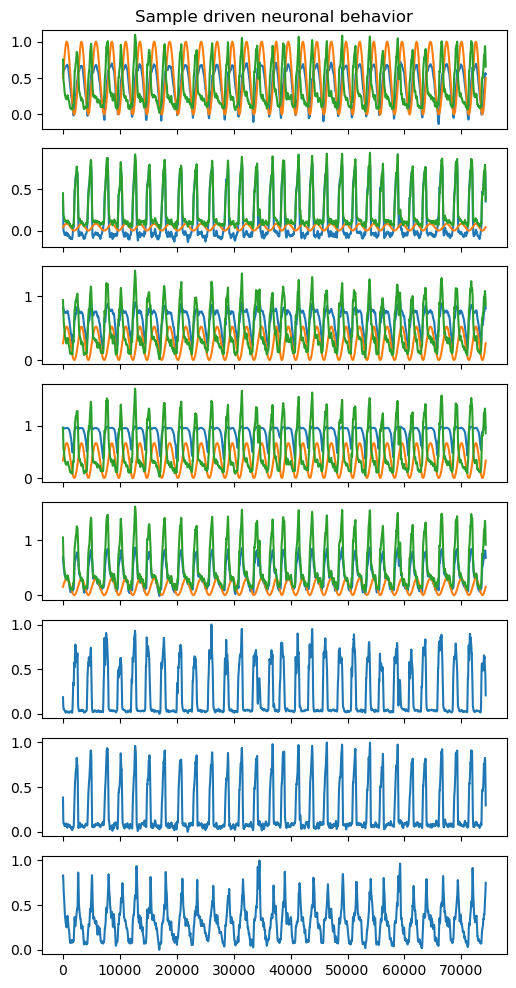

In [10]:
n_plot = 5

fig, axs = plt.subplots(n_plot + 3, 1, figsize = (6, 12), sharex = True)
for i in range(n_plot):
    axs[i].plot(Hxd[i])
    axs[i].plot(upsinind[i])
    axs[i].plot(ufoutd[i])

for i in range(3):
    axs[n_plot + i].plot(fouttrain[i])
    
axs[0].set_title("Sample driven neuronal behavior")

In [11]:
ufout = uhfout + upfout + uvfout

gain = 1
aux_targs = Hxd * gain + ufout
np.shape(aux_targs)

(1000, 74289)

### create and train a LIF network 

In [12]:
lifpars = create_default_params_LIF()

In [13]:
lifpars['net_size'] = netsize
lifpars['num_out'] = 3
lifpars['runtime'] = stop - start
lifpars['total_time'] = trainstop - start
lifpars['training_loops'] = 1000

In [14]:
lifnet = LIFTraining(lifpars)

In [15]:
# stabilize network
for i in range(3):
    lifnet.runGPU(upsinin)

In [16]:
lifnet.trainGPU(upsinin, aux_targs, fouttrain)

### observation of the network after training

In [17]:
voltage, slow, fast = lifnet.runGPU(upsinin)

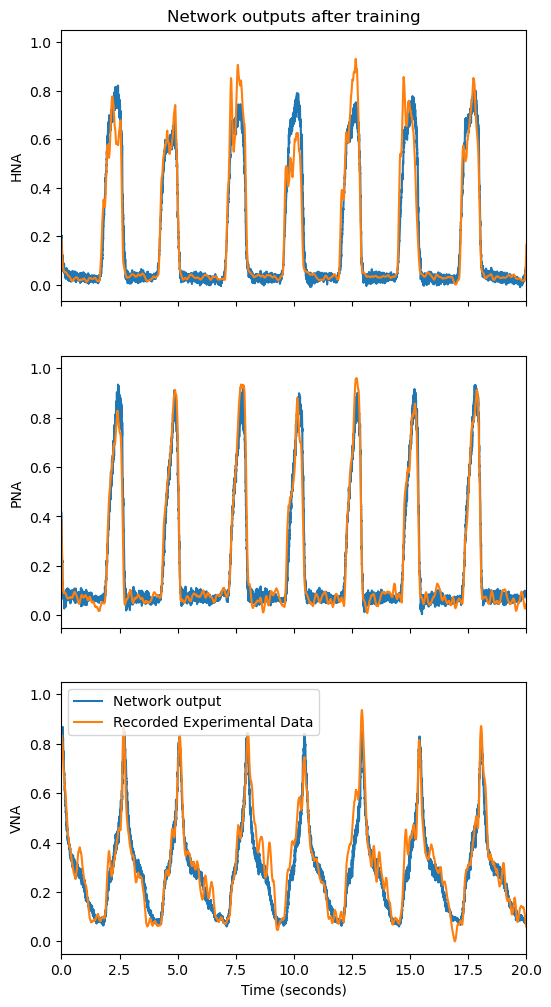

In [18]:
time = np.linspace(0, lifnet.run_time/1000, num = lifnet.run_time) 

Jslow = np.dot(lifnet.Js, slow)
wout = np.dot(lifnet.W_out, slow)
tot = stop - start
n_plot = 0
T = lifnet.T
dt = lifnet.dt

fig, axs = plt.subplots(n_plot + 3, 1, figsize = (6, 12), sharex = True)

for i in range(n_plot):
    axs[i].plot(time, Jslow[i])
    axs[i].plot(time, aux_targs[i, 0:tot])
    # axs[i].vlines(lifnet.T/1000, -0.25, 0.25)
for i in range(lifnet.num_outs):
    axs[n_plot + i].plot(time, wout[i])
    axs[n_plot + i].plot(time, fouttrain[i, 0:tot])
    # axs[n_plot + i].vlines(lifnet.T/1000, -0.25, 0.25)


axs[n_plot].set_ylabel("HNA")
axs[n_plot + 1].set_ylabel("PNA")
axs[n_plot + 2].set_ylabel("VNA")

axs[-1].set_xlabel("Time (seconds)")

axs[0].set_title("Network outputs after training")
axs[0].set_xlim(0, 20)

plt.subplots_adjust(wspace=None, hspace=None)
plt.legend(["Network output", "Recorded Experimental Data"])

Text(0.5, 1.0, 'Fast synapses after training')

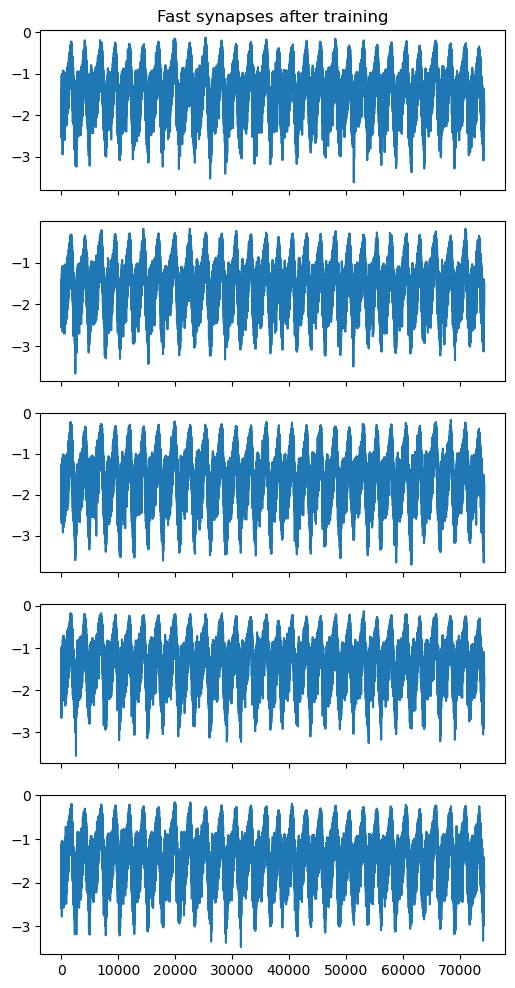

In [19]:
Jfast = np.dot(lifnet.Jf, fast)

n_plot = 5
T = lifnet.T
dt = lifnet.dt

fig, axs = plt.subplots(n_plot, 1, figsize = (6, 12), sharex = True)
for i in range(n_plot):
    axs[i].plot(Jfast[i])
axs[0].set_title("Fast synapses after training")

Text(0.5, 1.0, 'Membrane potential (voltage) after training')

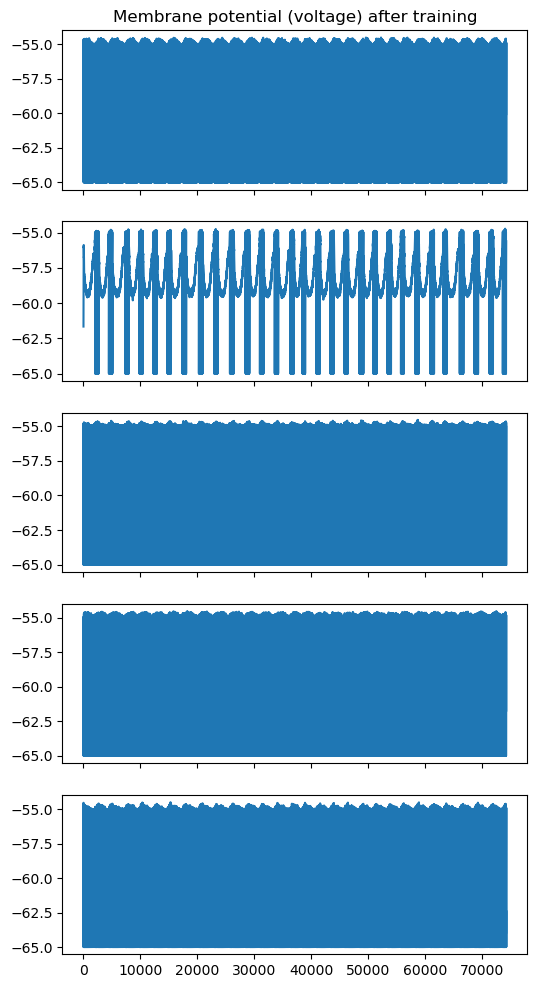

In [20]:
n_plot = 5
T = lifnet.T
dt = lifnet.dt

fig, axs = plt.subplots(n_plot, 1, figsize = (6, 12), sharex = True)
for i in range(n_plot):
    axs[i].plot(voltage[i])
axs[0].set_title("Membrane potential (voltage) after training")

In [21]:
spks = voltage > lifnet.v_thr
times = np.argwhere(spks)

spkt = []
for i in range(lifnet.N):
    spkt.append(times[times[:, 0] == i, 1])

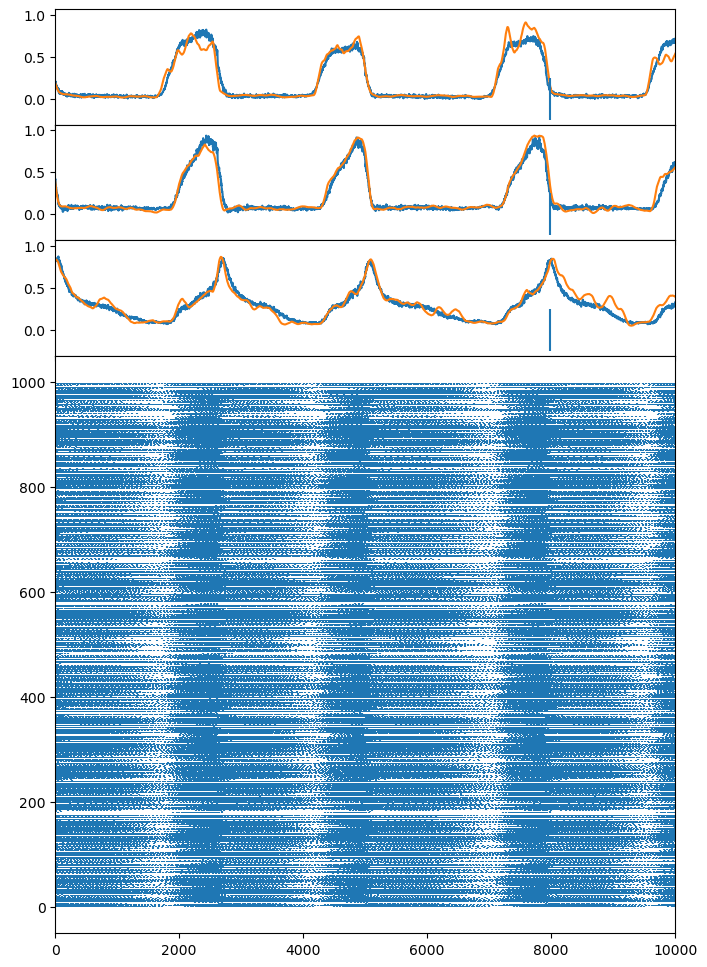

In [22]:
fig, axs = plt.subplots(4, 1, sharex=True, figsize=(8, 12), 
                        gridspec_kw=dict(hspace=0, height_ratios=[0.2, 0.2, 0.2, 1]))

for i in range(lifnet.num_outs):
    axs[i].plot(wout[i, :])
    axs[i].plot(fouttrain[i, :])
    axs[i].vlines(lifnet.T, -0.25, 0.25)

axs[3].eventplot(spkt);
axs[0].set_xlim([0, 10000]);
# axs[0].set_xlim([0, tot]);

In [23]:
inst_freqs = np.zeros(np.shape(spks))
for i in range(lifnet.N):
    freqs = 1000 / np.diff(spkt[i])
    for j in range(len(freqs)):
        inst_freqs[i, spkt[i][j]:spkt[i][j + 1]] = freqs[j]

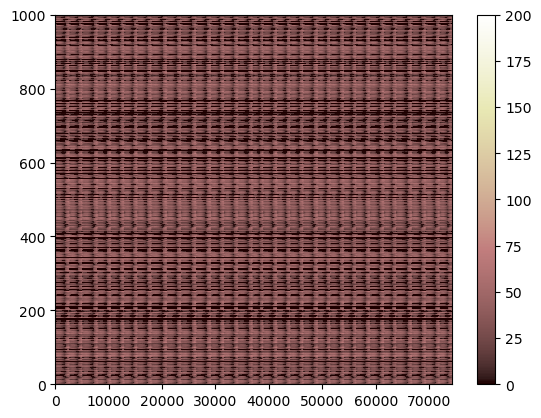

In [24]:
plt.pcolormesh(inst_freqs, cmap=plt.get_cmap('pink'), vmin = 0, vmax = 200)
plt.colorbar()

0.9715677445297966


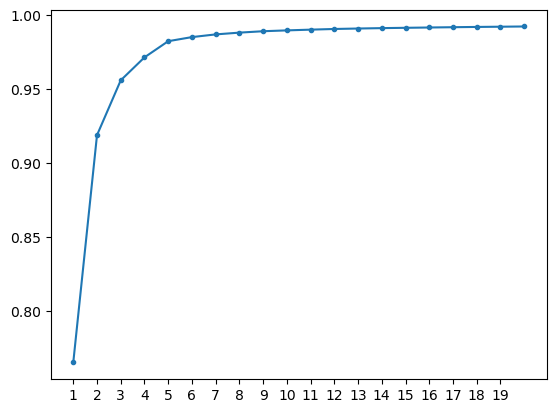

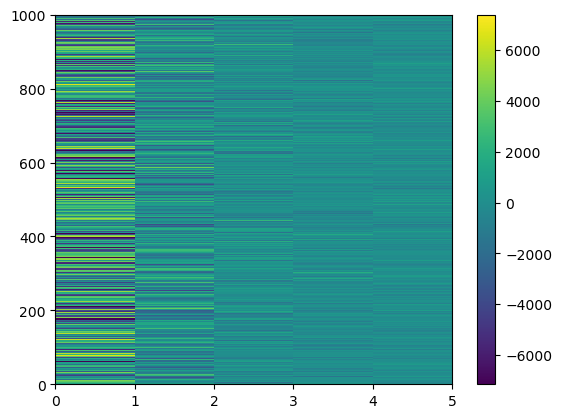

In [25]:
from sklearn.decomposition import PCA

N = 20
pca = PCA(n_components=N)
pca.fit(inst_freqs)

fig, ax = plt.subplots()
cumsum = np.cumsum(pca.explained_variance_ratio_)
ax.plot(np.arange(1, N+1), cumsum, '.-')
ax.set_xticks(np.arange(1, N))

print(np.sum(pca.explained_variance_ratio_[:4]))

N_star = 5
pca = PCA(n_components=N_star)
freqsw = pca.fit_transform(inst_freqs)

fig, ax = plt.subplots()
pcm = ax.pcolormesh(freqsw)
fig.colorbar(pcm)

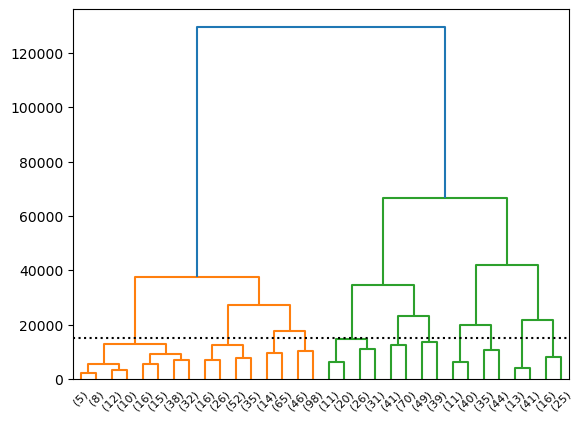

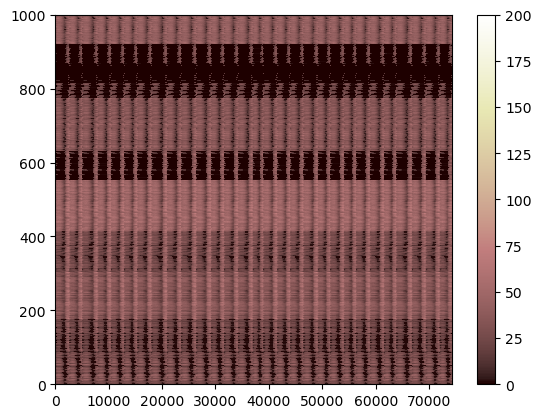

In [26]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

mdl = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

thresh = 15000

mdl.fit(freqsw)
fig, ax = plt.subplots()
plot_dendrogram(mdl, p=4, truncate_mode='level', ax=ax)
ax.axhline(thresh, color='k', linestyle=':')

mdl = AgglomerativeClustering(distance_threshold=thresh, n_clusters=None)
mdl.fit(freqsw)

clustered_idx = np.argsort(mdl.labels_)

fig, ax = plt.subplots()
pcm = ax.pcolormesh(inst_freqs[clustered_idx, :], cmap=plt.get_cmap('pink'), vmin = 0, vmax = 200)
fig.colorbar(pcm)
# pcm = ax.pcolormesh(np.arange(lifnet.N), np.arange(0, stop - start, lifnet.dt), inst_freqs[clustered_idx, :], cmap=plt.get_cmap('seismic'), vmin = -3, vmax = 3)

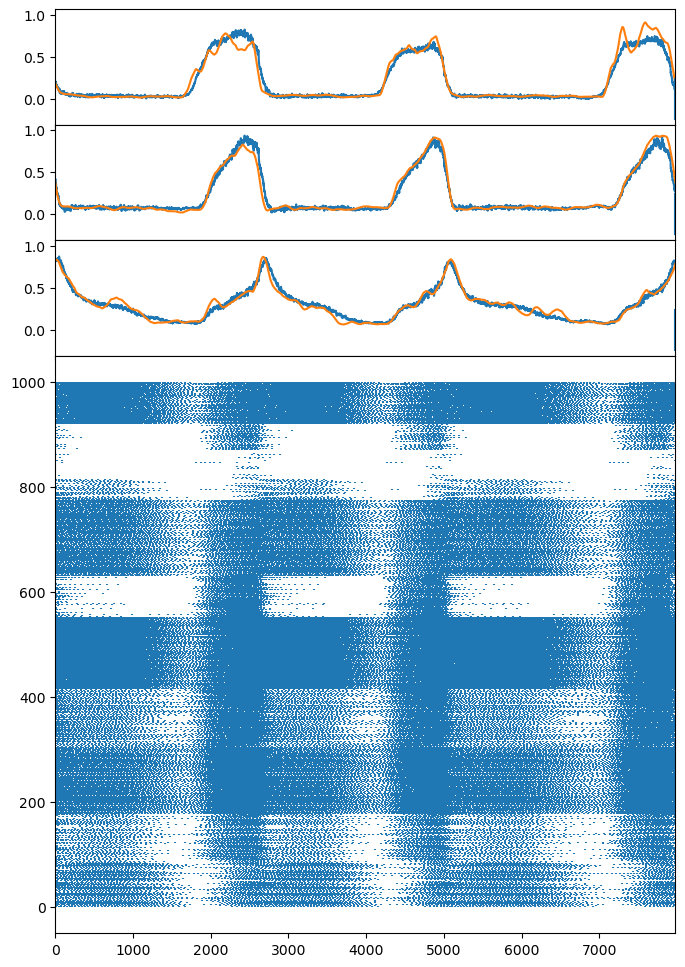

In [27]:
fig, axs = plt.subplots(4, 1, sharex=True, figsize=(8, 12), 
                        gridspec_kw=dict(hspace=0, height_ratios=[0.2, 0.2, 0.2, 1]))

for i in range(lifnet.num_outs):
    axs[i].plot(wout[i, :])
    axs[i].plot(fouttrain[i, :])
    axs[i].vlines(lifnet.T, -0.25, 0.25)
for i, c in enumerate(clustered_idx):
    axs[3].eventplot(spkt[c], lineoffsets=i);
axs[0].set_xlim([0, lifnet.T]);

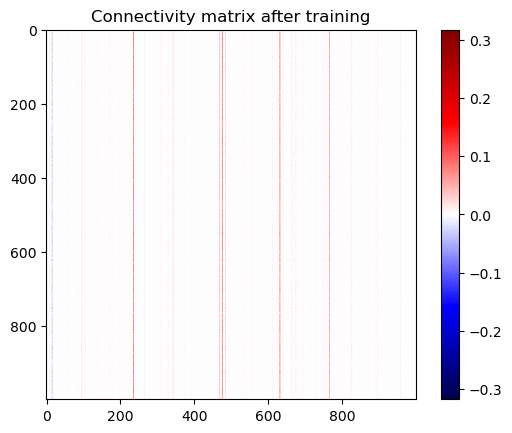

In [28]:
m = max(-1*np.min(lifnet.Js), np.max(lifnet.Js))

plt.imshow(lifnet.Js, cmap=plt.get_cmap('seismic'), vmin = -m, vmax = m)
plt.title("Connectivity matrix after training")
plt.colorbar()

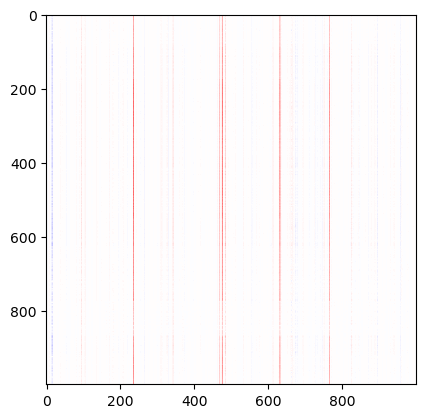

In [29]:
plt.imshow(lifnet.Js[clustered_idx], cmap=plt.get_cmap('seismic'), vmin = -m, vmax = m)

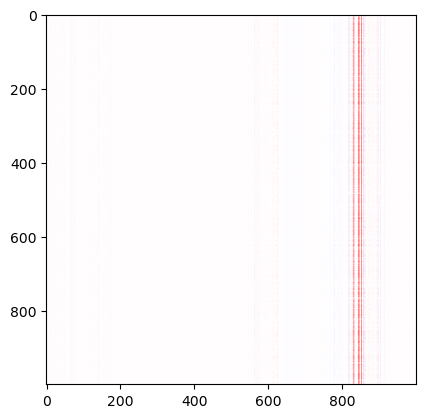

In [30]:
clust = lifnet.Js[:,:][:,clustered_idx]
plt.imshow(clust, cmap=plt.get_cmap('seismic'), vmin = -m, vmax = m)

c:\Users\lab\AppData\Local\miniconda3\envs\rnns\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\lab\AppData\Local\miniconda3\envs\rnns\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


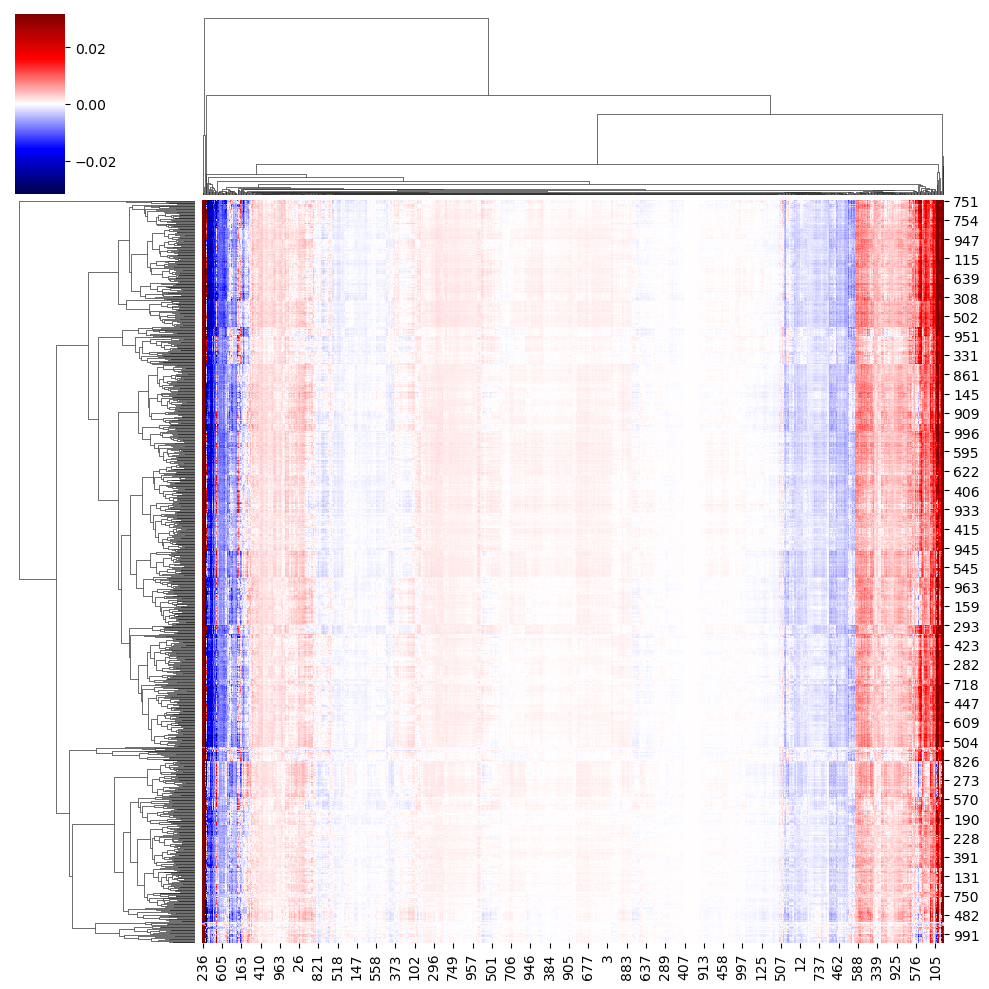

In [31]:
sns.clustermap(lifnet.Js, cmap=plt.get_cmap('seismic'), vmin = -m/10, vmax = m/10)

0.9930404094592928


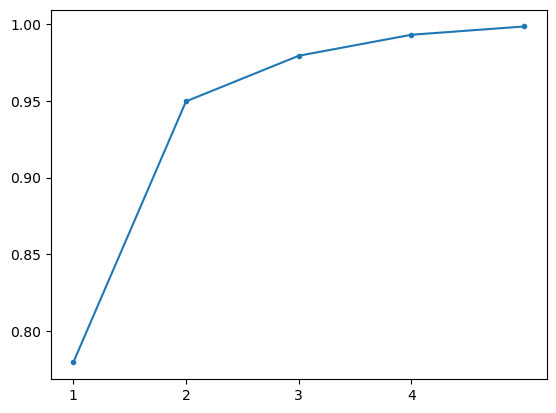

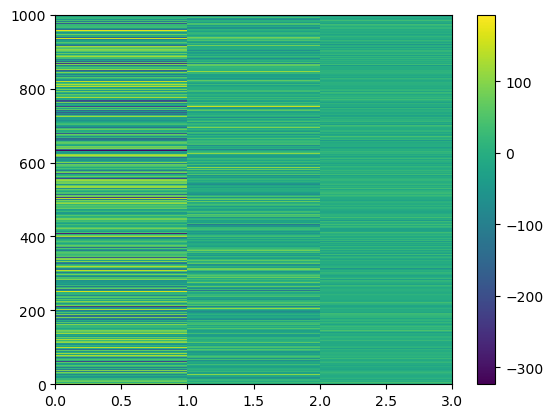

In [32]:
from sklearn.decomposition import PCA

N = 5
pca = PCA(n_components=N)
pca.fit(Jslow)

fig, ax = plt.subplots()
cumsum = np.cumsum(pca.explained_variance_ratio_)
ax.plot(np.arange(1, N+1), cumsum, '.-')
ax.set_xticks(np.arange(1, N))

print(np.sum(pca.explained_variance_ratio_[:4]))

N_star = 3
pca = PCA(n_components=N_star)
JslowPCA = pca.fit_transform(Jslow)

fig, ax = plt.subplots()
pcm = ax.pcolormesh(JslowPCA)
fig.colorbar(pcm)

### try running the network without an input

In [33]:
uzerosin = np.zeros((np.shape(ufin)))

In [34]:
voltagez, slowz, fastz = lifnet.runGPU(uzerosin)

Text(0.5, 1.0, 'Behavior after training with 0 stimulus')

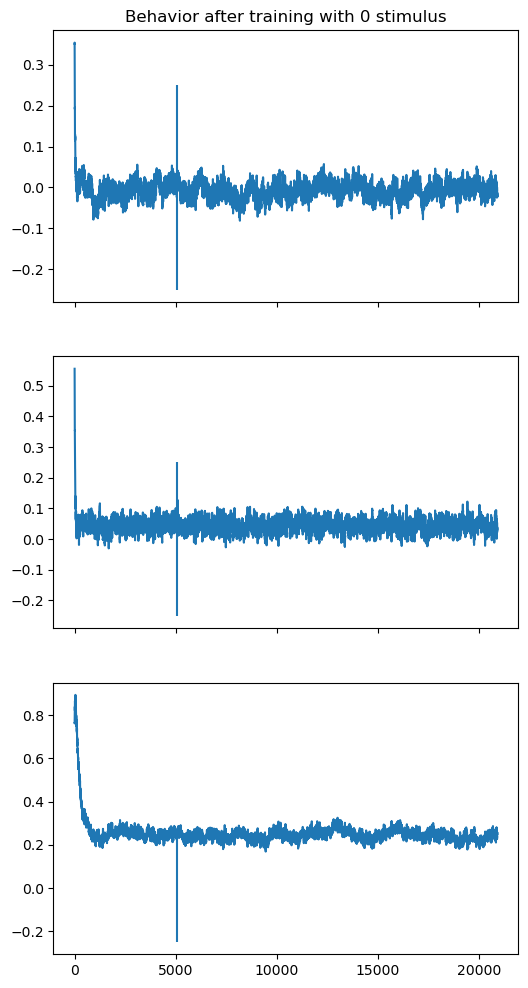

In [35]:
Jslowz = np.dot(lifnet.Js, slowz)
woutz = np.dot(lifnet.W_out, slowz)
tot = stop - start
n_plot = 0
T = lifnet.T
dt = lifnet.dt

fig, axs = plt.subplots(n_plot + 3, 1, figsize = (6, 12), sharex = True)
for i in range(n_plot):
    axs[i].plot(Jslowz[i])
    #axs[i].plot(aux_targs[i, 0:tot])
    axs[i].vlines(lifnet.T, -0.25, 0.25)
for i in range(lifnet.num_outs):
    axs[n_plot + i].plot(woutz[i])
    #axs[n_plot + i].plot(fouttrain[i, 0:tot])
    axs[n_plot + i].vlines(lifnet.T, -0.25, 0.25)

axs[0].set_title("Behavior after training with 0 stimulus")

In [36]:
sp.signal.find_peaks(woutz[2], distance=1800)

(array([   41,  2248,  5248,  7429, 10088, 13014, 16110, 18151, 20705],
       dtype=int64),
 {})

### save variables that change between runs

In [37]:
np.save("aux_targs", aux_targs)
np.save("ufin", ufin)

np.save("W_out", lifnet.W_out)
np.save("Js", lifnet.Js)
np.save("Jf", lifnet.Jf)